In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import likelihood
import pandas as pd
import numpy as np

### Example model and data

Models should have the form:
```
def some_model(param1,param2,param3,...other_args,...other_kwargs):
    return observable
```

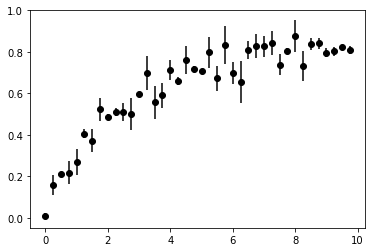

,X,Y,Y_stdev,residual,weighted_residual
0,0.00,0.010697,0.010697,0.010697,1.0
1,0.25,0.158333,0.047222,0.047222,1.0
2,0.50,0.209849,0.009849,0.009849,1.0
3,0.75,0.217865,0.054863,-0.054863,-1.0
4,1.00,0.268995,0.064339,-0.064339,-1.0


In [12]:
def binding_model(K,X=None):
    """
    Simple, saturating binding curve.

    K: association constant
    X: vector of X concentrations
    """

    return K*X/(1 + K*X)

df = pd.read_csv("binding-curves_noise-0.050.csv",index_col=0)

fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")
plt.show()

df.head()

### Wrap the binding model

In [13]:
mw = likelihood.ModelWrapper(binding_model)
print(mw.fit_parameters)
print(mw.other_arguments)

{'K': <likelihood.fit_param.FitParameter object at 0x11733e898>}
{'X': None}


In [14]:
mw.X = df.X
mw.K = 22
mw.K.bounds = [-20,20]
mw.K.name = "equilibrium constant"

/Users/harmsm/work/programming/git-clones/likelihood/likelihood/fit_param.py:265: UserWarning: The previous guess (22.0) is outside the new bounds ([-20.  20.])
Guess has been updated to 20.0

  warnings.warn(w,UserWarning)


### Construct the fitter and do the fit

In [15]:
f = likelihood.MLFitter()
f.model = mw
#lm.K.guess = 22
#lm.K.fixed = False
f.fit(y_obs=df.Y)
f.fit_to_df

,param,estimate,stdev,low_95,high_95,guess,lower_bound,upper_bound,fixed
0,equilibrium constant,0.493423,0.280837,-0.075103,1.061949,20.0,-20.0,20.0,False


In [16]:
f = likelihood.MLFitter()
f.fit(model=mw.model,guesses=[1.0],y_obs=df.Y,)
print(f.success)
print(f.estimate)
f.fit_to_df

True
[0.49342315]


,param,estimate,stdev,low_95,high_95,guess,lower_bound,upper_bound,fixed
0,equilibrium constant,0.493423,0.280837,-0.075103,1.061949,1.0,-20.0,20.0,False


### Alternate way to construct fitter and do fit

In [17]:
f = likelihood.MLFitter()
f.model = mw.model
f.guesses = [1]
f.y_obs = df.Y
f.fit()
print(f.success)
print(f.estimate)
f.fit_to_df

True
[0.49342315]


,param,estimate,stdev,low_95,high_95,guess,lower_bound,upper_bound,fixed
0,equilibrium constant,0.493423,0.280837,-0.075103,1.061949,1.0,-20.0,20.0,False


### Add weighted residuals

In [18]:
f = likelihood.MLFitter()
f.fit(model=mw.model,y_obs=df.Y,y_stdev=df.Y_stdev)
print(f.success)
print(f.estimate)
f.fit_to_df

True
[0.49837013]


,param,estimate,stdev,low_95,high_95,guess,lower_bound,upper_bound,fixed
0,equilibrium constant,0.49837,0.000851,0.496646,0.500094,1.0,-20.0,20.0,False


### Plotting

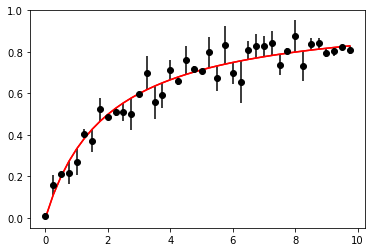

In [19]:
# Plot the fit
fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")
ax.plot(df.X,mw.model(),"-",color='red')
ax.plot(df.X,mw.model(f.estimate),"-",color='red')

### Corner plot

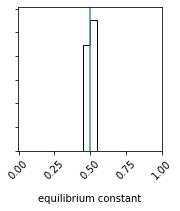

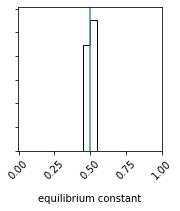

In [20]:
f.corner_plot()

### You can add parameter bounds and names

In [22]:
mw.bounds

array([[-20.],
       [ 20.]])

In [23]:
f = likelihood.MLFitter()
f.model = mw.model
f.guesses = [1.0]
f.y_obs = df.Y
f.y_stdev = df.Y_stdev
f.bounds = [[0],[np.inf]]
f.param_names = ["Kx"]
f.fit()
print(f.success)
print(f.estimate)
f.fit_to_df

True
[0.49837013]


,param,estimate,stdev,low_95,high_95,guess,lower_bound,upper_bound,fixed
0,equilibrium constant,0.49837,0.000851,0.496646,0.500094,1.0,0.0,inf,False


### Bayesian fitter

In [24]:
f = likelihood.BayesianFitter()
f.fit(model=mw.model,guesses=[1.0],y_obs=df.Y,y_stdev=df.Y_stdev)
print(f.success)
print(f.estimate)
f.fit_to_df


100%|██████████| 100/100 [00:09<00:00, 10.45it/s]


True
[0.49832093]


,param,estimate,stdev,low_95,high_95,guess,lower_bound,upper_bound,fixed
0,equilibrium constant,0.498321,0.001137,0.496026,0.500581,1.0,0.0,inf,False


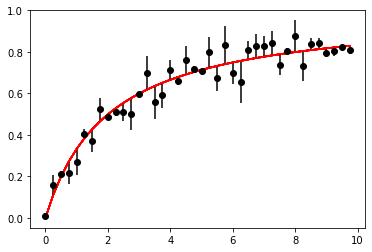

In [25]:
fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")

# Plot 100 fits sampled from posterior
for i in range(0,len(f.samples),90):
    ax.plot(df.X,mw.model(f.samples[i,:]),"-",color='red',alpha=0.1)